Starting enhanced backtest for SPY from 2020-01-01 to 2023-12-31...
Attempting to download stock data from 2019-07-05 to 2023-12-31...
Raw stock data downloaded. Shape: (1131, 5)
HV column created. Number of NaNs in HV (initial): 30
Stock data filtered to start_date 2020-01-01. Shape: (1006, 8)
After dropping NaNs from HV: 1006 -> 1006 rows. Dropped 0 rows.
Stock data prepared for backtest. Final total trading days: 1006
Minimum acceptable credit per spread (after all commissions and buffer): $2.70

--- Backtest Summary ---
Total Closed Trades: 897
Successful Trades: 659
Losing Trades: 238
Win Rate: 73.47%
Total Net PnL (from initial capital to final value): $131382.47
Average Net PnL per Closed Trade: $-194.95
Max Win (single closed trade): $353.67
Max Loss (single closed trade): $-1851.59

--- Portfolio Performance ---
Initial Capital: $100000.00
Final Portfolio Value: $231382.47
CAGR: 23.40%
Max Drawdown: -19.02%
Sharpe Ratio (Annualized): 1.47


NameError: name 'symbol' is not defined

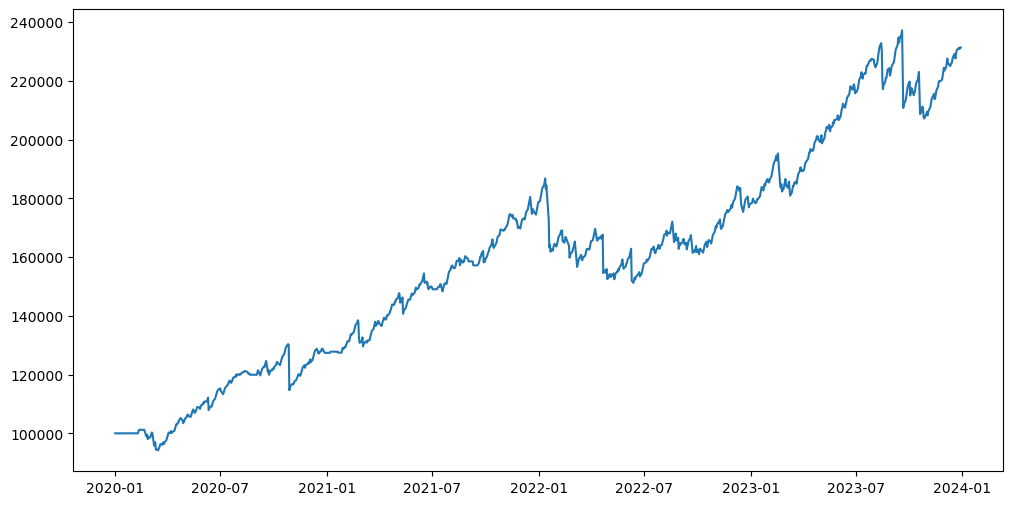

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, date, timedelta
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

# --- 1. Black-Scholes Model Implementation with Greeks ---
def black_scholes_greeks(S, K, T, r, sigma, option_type="call"):
    """
    Calculates Black-Scholes option price and Greeks.
    S: Stock price
    K: Strike price
    T: Time to expiration (in years)
    r: Risk-free rate (annualized)
    sigma: Volatility (annualized)
    option_type: "call" or "put"
    """
    if T <= 0 or sigma <= 0:
        # For options at or near expiry, or with zero volatility, return intrinsic value
        # Greeks will be NaN as they are derivatives w.r.t. T or sigma
        price = 0.0
        if option_type == "call":
            price = max(0, S - K)
        else: # put
            price = max(0, K - S)
        return {'price': price, 'delta': np.nan, 'gamma': np.nan,
                'vega': np.nan, 'theta': np.nan, 'rho': np.nan}

    S = float(S)
    K = float(K)
    T = float(T)
    r = float(r)
    sigma = float(sigma)

    # Calculate d1 and d2
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)

    if option_type == "call":
        price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
        delta = norm.cdf(d1)
        # Theta is typically expressed per day, so divide by 365
        theta = (-S * norm.pdf(d1) * sigma / (2 * math.sqrt(T)) - r * K * math.exp(-r * T) * norm.cdf(d2)) / 365
        rho = K * T * math.exp(-r * T) * norm.cdf(d2) / 100 # Per 1% change in interest rate
    elif option_type == "put":
        price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        delta = norm.cdf(d1) - 1
        theta = (-S * norm.pdf(d1) * sigma / (2 * math.sqrt(T)) + r * K * math.exp(-r * T) * norm.cdf(-d2)) / 365
        rho = -K * T * math.exp(-r * T) * norm.cdf(-d2) / 100
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    gamma = norm.pdf(d1) / (S * sigma * math.sqrt(T))
    vega = S * norm.pdf(d1) * math.sqrt(T) / 100 # Per 1% change in volatility

    return {
        'price': price, 'delta': delta, 'gamma': gamma,
        'vega': vega, 'theta': theta, 'rho': rho
    }

# --- Helper Function to Find Next Realistic Expiry Date ---
def find_next_expiry_date(current_date, min_dte, max_dte):
    """
    Simulates finding the next realistic options expiry date (weekly/monthly)
    within a specified DTE range. Prioritizes shortest DTE within range.
    """
    for days_ahead in range(min_dte, max_dte + 1):
        test_date = current_date + timedelta(days=days_ahead)
        
        # We're simplifying to target Fridays for weekly/monthly
        # This is a heuristic, real options dates vary.
        if test_date.weekday() == 4: # Friday is 4
            return test_date
    return None # No suitable expiry found

# --- 3. Backtesting Function (Enhanced) ---
def backtest_short_volatility_credit_spread_enhanced(
    symbol="SPY",
    start_date="2020-01-01",
    end_date="2023-12-31",
    initial_capital=100000,
    risk_free_rate=0.01,
    hv_lookback_days=30,
    iv_to_hv_ratio_entry=1.5, # Enter if "theoretical" IV > this * HV
    target_delta_min=0.20,    # Minimum absolute delta for short leg
    target_delta_max=0.40,    # Maximum absolute delta for short leg
    spread_width=5.0,         # e.g., $5.00 wide spread
    max_portfolio_risk_per_trade_pct=0.005, # Max % of portfolio value to risk per trade (e.g., 0.5%)
    commission_per_contract=0.65, # Realistic commission per contract (e.g., $0.65)
    target_dte_min=7,         # Min Days to Expiration for trade entry
    target_dte_max=45,        # Max Days to Expiration for trade entry
    profit_target_pct=0.50,   # Close when profit reaches X% of max credit
    stop_loss_multiple=1.0,   # Close when loss reaches X times initial credit
    min_profit_buffer_per_spread=0.05 # Minimum desired profit per spread after all commissions
):
    print(f"Starting enhanced backtest for {symbol} from {start_date} to {end_date}...")

    # Adjust download start date to ensure enough data for initial HV calculation
    download_start_date_dt = pd.to_datetime(start_date) - timedelta(days=hv_lookback_days + 150)
    download_start_date = download_start_date_dt.strftime('%Y-%m-%d')
    
    print(f"Attempting to download stock data from {download_start_date} to {end_date}...")
    df = yf.download(symbol, start=download_start_date, end=end_date, auto_adjust=True, progress=False)

    if df.empty:
        print(f"ERROR: No historical stock data downloaded for {symbol}. Check symbol or date range.")
        return pd.DataFrame(), None
    
    # --- Handle MultiIndex Columns from yfinance ---
    if isinstance(df.columns, pd.MultiIndex):
        # Flatten the MultiIndex: drop the ticker level (level 1)
        df.columns = df.columns.droplevel(1)
        # Ensure 'Close' column is directly accessible
        if 'Close' not in df.columns:
            # Fallback for cases where dropping level 1 might result in empty string for level 0
            if ('Close', '') in df.columns: # Sometimes it becomes ('Close', '')
                df = df.rename(columns={('Close', ''): 'Close'})
            else: # If still not found, print error
                print(f"ERROR: No 'Close' column found in downloaded data after flattening MultiIndex. Columns are: {df.columns.tolist()}")
                return pd.DataFrame(), None
    
    if 'Close' not in df.columns: # Final check for 'Close' column
        print(f"ERROR: 'Close' column not found in downloaded data for {symbol}. Columns are: {df.columns.tolist()}")
        return pd.DataFrame(), None

    print(f"Raw stock data downloaded. Shape: {df.shape}")

    if len(df) < hv_lookback_days + 1:
        print(f"ERROR: Not enough raw historical stock data ({len(df)} days) downloaded for {hv_lookback_days} lookback period. Required: {hv_lookback_days + 1}")
        return pd.DataFrame(), None

    # --- Calculate Historical Volatility (HV) ---
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Daily_HV'] = df['Log_Returns'].rolling(window=hv_lookback_days).std()
    df['HV'] = df['Daily_HV'] * np.sqrt(252) # Annualize

    print(f"HV column created. Number of NaNs in HV (initial): {df['HV'].isnull().sum()}")

    # Filter DataFrame to the actual backtest start date and drop NaNs in HV
    df_filtered = df[df.index >= pd.to_datetime(start_date)].copy()
    print(f"Stock data filtered to start_date {start_date}. Shape: {df_filtered.shape}")

    if df_filtered.empty:
        print(f"ERROR: DataFrame is empty after filtering to start_date {start_date}.")
        return pd.DataFrame(), None

    if 'HV' not in df_filtered.columns:
        print(f"CRITICAL ERROR: 'HV' column missing in df_filtered AFTER filtering. Columns present: {df_filtered.columns.tolist()}")
        return pd.DataFrame(), None
        
    if df_filtered['HV'].isnull().all():
        print("CRITICAL ERROR: 'HV' column is ALL NaNs after filtering. This indicates HV calculation failed consistently.")
        return pd.DataFrame(), None

    initial_rows = len(df_filtered)
    df_filtered.dropna(subset=['HV'], inplace=True)
    rows_after_dropna = len(df_filtered)
    print(f"After dropping NaNs from HV: {initial_rows} -> {rows_after_dropna} rows. Dropped {initial_rows - rows_after_dropna} rows.")

    if df_filtered.empty:
        print("ERROR: DataFrame became empty after dropping NaNs from 'HV'. Not enough valid HV data remaining.")
        return pd.DataFrame(), None

    df_filtered.index = pd.to_datetime(df_filtered.index)
    df_filtered['Date'] = df_filtered.index
    df_filtered.reset_index(drop=True, inplace=True)

    print(f"Stock data prepared for backtest. Final total trading days: {len(df_filtered)}")
    if len(df_filtered) <= 1:
        print("ERROR: Not enough trading days for strategy execution after all filters.")
        return pd.DataFrame(), None

    # --- Portfolio Tracking Initialization ---
    trades = [] # Stores completed trades
    portfolio_history = [] # Stores daily portfolio snapshot
    cash = initial_capital
    open_positions = [] # List of dictionaries, each representing an open spread position

    # Commission per spread (2 contracts: short & long)
    commission_per_spread_open = commission_per_contract * 2
    commission_per_spread_close = commission_per_contract * 2
    
    # Define minimum acceptable credit per spread based on commissions and desired buffer
    # This is the CRITICAL adjustment: ensures credit covers all commissions + desired profit
    min_acceptable_credit_per_spread = commission_per_spread_open + commission_per_spread_close + min_profit_buffer_per_spread
    print(f"Minimum acceptable credit per spread (after all commissions and buffer): ${min_acceptable_credit_per_spread:.2f}")


    # --- Main Backtest Loop (Day by Day) ---
    for i in range(len(df_filtered)):
        current_date = df_filtered.loc[i, 'Date']
        current_price = df_filtered.loc[i, 'Close']
        current_hv = df_filtered.loc[i, 'HV']
        
        pnl_today_closed_trades = 0 # Track PnL from closed trades on this specific day

        # --- 3.1. Position Management (Check Open Positions for Expiry/Early Exit) ---
        # Iterate over a copy to safely modify the original list
        for pos in list(open_positions): 
            # Calculate remaining DTE for early exit
            remaining_dte = (pos['expiry_date'] - current_date).days

            # Check for Expiry
            if current_date >= pos['expiry_date']:
                outcome = 0.0 # Gross PnL per spread (before closing commission)
                reason = 'Expiration'

                if pos['type'] == 'call':
                    if current_price < pos['short_strike']: # Both OTM, max profit
                        outcome = pos['credit_received'] 
                    elif current_price >= pos['short_strike'] and current_price <= pos['long_strike']: # Short ITM, Long OTM/less ITM
                        outcome = pos['credit_received'] - (current_price - pos['short_strike']) 
                    else: # Both ITM, max loss
                        outcome = -(pos['max_loss']) 
                elif pos['type'] == 'put':
                    if current_price > pos['short_strike']: # Both OTM, max profit
                        outcome = pos['credit_received'] 
                    elif current_price <= pos['short_strike'] and current_price >= pos['long_strike']: # Short ITM, Long OTM/less ITM
                        outcome = pos['credit_received'] - (pos['short_strike'] - current_price) 
                    else: # Both ITM, max loss
                        outcome = -(pos['max_loss']) 
                
                trade_pnl_net = (outcome * pos['num_spreads']) - (commission_per_spread_close * pos['num_spreads'])
                pnl_today_closed_trades += trade_pnl_net
                cash += trade_pnl_net # Update cash with net PnL from this closed trade
                
                # print(f"DEBUG: {current_date} - Trade closed. ID: {pos['trade_id']}, Reason: {reason}. Net PnL (total): {trade_pnl_net:.2f}")

                trades.append({
                    'Trade ID': pos['trade_id'],
                    'Entry Date': pos['entry_date'],
                    'Exit Date': current_date,
                    'Type': pos['type'],
                    'Short Strike': pos['short_strike'],
                    'Long Strike': pos['long_strike'],
                    'Credit Received (per spread)': pos['credit_received'],
                    'Max Loss (per spread)': pos['max_loss'],
                    'Num Spreads': pos['num_spreads'],
                    'Gross PnL (per spread)': outcome,
                    'Net PnL (total)': trade_pnl_net,
                    'Reason': reason
                })
                open_positions.remove(pos) # Remove from active positions

            # --- Early Exit Logic (Simplified Mark-to-Market) ---
            elif remaining_dte > 0: # Only if not expired yet
                time_to_expiry_years_current = remaining_dte / 365.0
                
                current_theoretical_iv = current_hv * iv_to_hv_ratio_entry # Use entry IV ratio for consistency
                
                try:
                    current_short_price = black_scholes_greeks(
                        S=current_price, K=pos['short_strike'], T=time_to_expiry_years_current,
                        r=risk_free_rate, sigma=current_theoretical_iv, option_type=pos['type']
                    )['price']
                    current_long_price = black_scholes_greeks(
                        S=current_price, K=pos['long_strike'], T=time_to_expiry_years_current,
                        r=risk_free_rate, sigma=current_theoretical_iv, option_type=pos['type']
                    )['price']
                    
                    # Cost to close the spread (debit to close)
                    # For a credit spread: to close, you typically BUY the short leg and SELL the long leg.
                    # The cost is (short_leg_current_price - long_leg_current_price)
                    cost_to_close_per_spread = current_short_price - current_long_price
                    
                    # PnL from entry (credit received) to current mark-to-market (cost to close)
                    current_gross_pnl_per_spread = pos['credit_received'] - cost_to_close_per_spread
                    
                    # Profit Target (e.g., close at 50% of max credit received)
                    if current_gross_pnl_per_spread >= (pos['credit_received'] * profit_target_pct):
                        reason = 'Profit Target'
                        trade_pnl_net = (current_gross_pnl_per_spread * pos['num_spreads']) - (commission_per_spread_close * pos['num_spreads'])
                        pnl_today_closed_trades += trade_pnl_net
                        cash += trade_pnl_net
                        
                        # print(f"DEBUG: {current_date} - Early closing (Reason: {reason}). ID: {pos['trade_id']}. Net PnL (total): {trade_pnl_net:.2f}")

                        trades.append({
                            'Trade ID': pos['trade_id'],
                            'Entry Date': pos['entry_date'],
                            'Exit Date': current_date,
                            'Type': pos['type'],
                            'Short Strike': pos['short_strike'],
                            'Long Strike': pos['long_strike'],
                            'Credit Received (per spread)': pos['credit_received'],
                            'Max Loss (per spread)': pos['max_loss'],
                            'Num Spreads': pos['num_spreads'],
                            'Gross PnL (per spread)': current_gross_pnl_per_spread,
                            'Net PnL (total)': trade_pnl_net,
                            'Reason': reason
                        })
                        open_positions.remove(pos)

                    # Stop Loss (e.g., close if loss is equal to credit received)
                    elif current_gross_pnl_per_spread <= -(pos['credit_received'] * stop_loss_multiple):
                        reason = 'Stop Loss'
                        trade_pnl_net = (current_gross_pnl_per_spread * pos['num_spreads']) - (commission_per_spread_close * pos['num_spreads'])
                        pnl_today_closed_trades += trade_pnl_net
                        cash += trade_pnl_net
                        
                        # print(f"DEBUG: {current_date} - Early closing (Reason: {reason}). ID: {pos['trade_id']}. Net PnL (total): {trade_pnl_net:.2f}")

                        trades.append({
                            'Trade ID': pos['trade_id'],
                            'Entry Date': pos['entry_date'],
                            'Exit Date': current_date,
                            'Type': pos['type'],
                            'Short Strike': pos['short_strike'],
                            'Long Strike': pos['long_strike'],
                            'Credit Received (per spread)': pos['credit_received'],
                            'Max Loss (per spread)': pos['max_loss'],
                            'Num Spreads': pos['num_spreads'],
                            'Gross PnL (per spread)': current_gross_pnl_per_spread,
                            'Net PnL (total)': trade_pnl_net,
                            'Reason': reason
                        })
                        open_positions.remove(pos)

                except Exception as e:
                    # print(f"Warning: Error during early exit valuation for position ID {pos.get('trade_id', 'N/A')}: {e}")
                    pass # Continue if error in valuation

        # --- 3.2. New Trade Entry Logic ---
        if pd.isna(current_hv) or current_hv <= 0:
            pass # Skip trade entry if HV is invalid
        else:
            theoretical_iv = current_hv * iv_to_hv_ratio_entry
            if not (0.05 < theoretical_iv < 2.0): # Filter out unrealistic IVs
                pass
            else:
                # Find a realistic expiry date
                expiry_date_for_new_trade = find_next_expiry_date(current_date, target_dte_min, target_dte_max)
                if not expiry_date_for_new_trade:
                    pass
                else:
                    time_to_expiry_days = (expiry_date_for_new_trade - current_date).days
                    time_to_expiry_years = time_to_expiry_days / 365.0
                    
                    if time_to_expiry_days <= 0: # Ensure it's truly in the future
                        pass
                    else:
                        # Generate potential short strikes around the current price
                        strike_step = 1 # Assuming strikes are in $1 increments for SPY
                        # Generate strikes +/- 10% of current price, but ensure at least +/- 20 strikes for $1 steps
                        min_strike_range = max(20, int(current_price * 0.10 / strike_step))
                        
                        potential_short_strikes = np.arange(
                            max(1, int((current_price - min_strike_range * strike_step) / strike_step) * strike_step),
                            int((current_price + min_strike_range * strike_step) / strike_step) * strike_step + strike_step,
                            strike_step
                        ).tolist()
                        potential_short_strikes = [s for s in potential_short_strikes if s > 0]
                        
                        if not potential_short_strikes:
                            pass
                        else:
                            found_spread = False
                            trade_details = None

                            # Try to find a Put Credit Spread
                            for short_strike in potential_short_strikes:
                                if short_strike >= current_price: # Put strike must be OTM (below current price)
                                    continue

                                long_strike = short_strike - spread_width
                                if long_strike <= 0: continue # Long strike must be positive

                                # Calculate theoretical prices for short and long leg
                                try:
                                    short_put_greeks = black_scholes_greeks(
                                        S=current_price, K=short_strike, T=time_to_expiry_years,
                                        r=risk_free_rate, sigma=theoretical_iv, option_type="put"
                                    )
                                    long_put_greeks = black_scholes_greeks(
                                        S=current_price, K=long_strike, T=time_to_expiry_years,
                                        r=risk_free_rate, sigma=theoretical_iv, option_type="put"
                                    )
                                except Exception:
                                    continue
                                
                                abs_delta_short_put = abs(short_put_greeks['delta']) if not pd.isna(short_put_greeks['delta']) else -1

                                # Ensure delta is within target range for the short leg
                                if abs_delta_short_put >= target_delta_min and \
                                   abs_delta_short_put <= target_delta_max:
                                    
                                    credit_received = short_put_greeks['price'] - long_put_greeks['price']
                                    
                                    # Only consider spreads that offer enough credit to cover commissions and a profit margin
                                    if credit_received >= min_acceptable_credit_per_spread:
                                        trade_details = {
                                            'type': 'put',
                                            'entry_date': current_date,
                                            'expiry_date': expiry_date_for_new_trade,
                                            'short_strike': short_strike,
                                            'long_strike': long_strike,
                                            'credit_received': credit_received,
                                            'max_loss': spread_width - credit_received
                                        }
                                        found_spread = True
                                        break

                            if not found_spread:
                                # Try to find a Call Credit Spread
                                for short_strike in sorted(potential_short_strikes, reverse=True): # Iterate from higher strikes down
                                    if short_strike <= current_price: # Call strike must be OTM (above current price)
                                        continue

                                    long_strike = short_strike + spread_width
                                    
                                    # Calculate theoretical prices for short and long leg
                                    try:
                                        short_call_greeks = black_scholes_greeks(
                                            S=current_price, K=short_strike, T=time_to_expiry_years,
                                            r=risk_free_rate, sigma=theoretical_iv, option_type="call"
                                        )
                                        long_call_greeks = black_scholes_greeks(
                                            S=current_price, K=long_strike, T=time_to_expiry_years,
                                            r=risk_free_rate, sigma=theoretical_iv, option_type="call"
                                        )
                                    except Exception:
                                        continue

                                    abs_delta_short_call = short_call_greeks['delta'] if not pd.isna(short_call_greeks['delta']) else -1

                                    # Ensure delta is within target range for the short leg
                                    if abs_delta_short_call >= target_delta_min and \
                                       abs_delta_short_call <= target_delta_max:
                                        
                                        credit_received = short_call_greeks['price'] - long_call_greeks['price']
                                        
                                        # Only consider spreads that offer enough credit to cover commissions and a profit margin
                                        if credit_received >= min_acceptable_credit_per_spread:
                                            trade_details = {
                                                'type': 'call',
                                                'entry_date': current_date,
                                                'expiry_date': expiry_date_for_new_trade,
                                                'short_strike': short_strike,
                                                'long_strike': long_strike,
                                                'credit_received': credit_received,
                                                'max_loss': spread_width - credit_received
                                            }
                                            found_spread = True
                                            break
                            
                            # If a suitable spread is found, calculate sizing and open
                            if found_spread:
                                # Assign a unique ID for easier tracking
                                trade_details['trade_id'] = len(trades) + len(open_positions) + 1 

                                # Dynamic position sizing based on current portfolio value
                                # Simplified: assume open positions contribute their initial credit received
                                # For a more precise calculation, one would need mark-to-market of open positions
                                current_portfolio_value = cash + sum(pos['credit_received'] * pos['num_spreads'] for pos in open_positions) 
                                max_risk_dollars_for_this_trade = current_portfolio_value * max_portfolio_risk_per_trade_pct
                                
                                if trade_details['max_loss'] <= 0: # Avoid division by zero or negative risk spreads
                                    num_spreads = 0
                                else:
                                    # Ensure num_spreads doesn't exceed available buying power (capital / max_loss)
                                    # For credit spreads, the buying power reduction is max_loss per spread.
                                    num_spreads = math.floor(max_risk_dollars_for_this_trade / trade_details['max_loss'])
                                
                                if num_spreads > 0:
                                    total_commission_to_open = num_spreads * commission_per_spread_open
                                    
                                    # Check if enough cash for commissions (even if net credit is positive)
                                    if cash >= total_commission_to_open: # Ensure enough liquidity for commissions
                                        trade_details['num_spreads'] = num_spreads
                                        open_positions.append(trade_details)
                                        
                                        # Update cash: credit received - opening commissions
                                        pnl_from_open = (trade_details['credit_received'] * num_spreads) - total_commission_to_open
                                        cash += pnl_from_open
                                        pnl_today_closed_trades += pnl_from_open # Credit is PnL at entry
                                        
                                        # print(f"DEBUG: {current_date} - Opening new {trade_details['type']} spread. ID: {trade_details['trade_id']}. Short: {trade_details['short_strike']}, Long: {trade_details['long_strike']}, Credit (per spread): {trade_details['credit_received']:.2f}, Max Loss (per spread): {trade_details['max_loss']:.2f}, Num Spreads: {num_spreads}, Net PnL from open: {pnl_from_open:.2f}, Current Cash: {cash:.2f}")

                                        # Log the opening of the position (PnL is initial credit - commissions)
                                        trades.append({
                                            'Trade ID': trade_details['trade_id'],
                                            'Entry Date': current_date,
                                            'Exit Date': None, # Still open
                                            'Type': trade_details['type'],
                                            'Short Strike': trade_details['short_strike'],
                                            'Long Strike': trade_details['long_strike'],
                                            'Credit Received (per spread)': trade_details['credit_received'],
                                            'Max Loss (per spread)': trade_details['max_loss'],
                                            'Num Spreads': trade_details['num_spreads'],
                                            'Gross PnL (per spread)': trade_details['credit_received'], # Gross credit received
                                            'Net PnL (total)': pnl_from_open,
                                            'Reason': 'Opened Position'
                                        })
                                    else:
                                        pass # Not enough cash to open trade
                                else:
                                    pass # Calculated num_spreads is 0
                            else:
                                pass # No suitable spread found

        # --- 3.3. Record Daily Portfolio State ---
        # Estimate current mark-to-market value of open positions
        # This is a simplification without real options data.
        # For simplicity, we'll assume open positions contribute their initial credit received
        # to the portfolio value, until they are closed. This ignores daily fluctuations.
        current_open_positions_value = sum(pos['credit_received'] * pos['num_spreads'] for pos in open_positions)
        
        portfolio_value_at_eod = cash + current_open_positions_value
        
        portfolio_history.append({
            'Date': current_date,
            'Cash': cash,
            'Portfolio Value': portfolio_value_at_eod,
            'Open Positions Count': len(open_positions),
            'PnL Today': pnl_today_closed_trades
        })

    # --- Finalize any remaining open positions at the end of the backtest period ---
    # Force-close any open positions at the end of the backtest
    for pos in open_positions:
        # Calculate current market value to close (as of last day of backtest)
        last_day_in_backtest = df_filtered.loc[len(df_filtered) - 1, 'Date']
        last_price = df_filtered.loc[len(df_filtered) - 1, 'Close']
        last_hv = df_filtered.loc[len(df_filtered) - 1, 'HV']

        remaining_dte_final = (pos['expiry_date'] - last_day_in_backtest).days
        
        outcome = 0.0 # Gross PnL from entry to final mark-to-market
        reason = 'Forced Close (End of Backtest)'

        if remaining_dte_final > 0 and last_hv > 0: # Can price if still time and valid HV
            try:
                time_to_expiry_years_final = remaining_dte_final / 365.0
                current_theoretical_iv_final = last_hv * iv_to_hv_ratio_entry 

                final_short_price = black_scholes_greeks(
                    S=last_price, K=pos['short_strike'], T=time_to_expiry_years_final,
                    r=risk_free_rate, sigma=current_theoretical_iv_final, option_type=pos['type']
                )['price']
                final_long_price = black_scholes_greeks(
                    S=last_price, K=pos['long_strike'], T=time_to_expiry_years_final,
                    r=risk_free_rate, sigma=current_theoretical_iv_final, option_type=pos['type']
                )['price']
                
                cost_to_close_per_spread_final = final_short_price - final_long_price
                outcome = pos['credit_received'] - cost_to_close_per_spread_final

            except Exception as e:
                # print(f"Warning: Error during final forced close valuation for position ID {pos.get('trade_id', 'N/A')}: {e}. Assuming max profit.")
                outcome = pos['credit_received'] # Fallback to max profit if error
        else: # Expired or no valid IV on last day, determine outcome based on final price
            if pos['type'] == 'call':
                if last_price < pos['short_strike']: # Both OTM, max profit
                    outcome = pos['credit_received'] 
                elif last_price >= pos['short_strike'] and last_price <= pos['long_strike']:
                    outcome = pos['credit_received'] - (last_price - pos['short_strike']) 
                else: # Both ITM, max loss
                    outcome = -(pos['max_loss']) 
            elif pos['type'] == 'put':
                if last_price > pos['short_strike']: # Both OTM, max profit
                    outcome = pos['credit_received'] 
                elif last_price <= pos['short_strike'] and last_price >= pos['long_strike']:
                    outcome = pos['credit_received'] - (pos['short_strike'] - last_price) 
                else: # Both ITM, max loss
                    outcome = -(pos['max_loss']) 
                
        trade_pnl_net = (outcome * pos['num_spreads']) - (commission_per_spread_close * pos['num_spreads'])
        
        # print(f"DEBUG: {end_date} - Forced closing position at end of backtest. ID: {pos['trade_id']}. Type: {pos['type']}, Net PnL (total): {trade_pnl_net:.2f}")

        trades.append({
            'Trade ID': pos['trade_id'],
            'Entry Date': pos['entry_date'],
            'Exit Date': end_date, # Forced close at end of backtest
            'Type': pos['type'],
            'Short Strike': pos['short_strike'],
            'Long Strike': pos['long_strike'],
            'Credit Received (per spread)': pos['credit_received'],
            'Max Loss (per spread)': pos['max_loss'],
            'Num Spreads': pos['num_spreads'],
            'Gross PnL (per spread)': outcome,
            'Net PnL (total)': trade_pnl_net,
            'Reason': reason
        })

    # Convert trades and portfolio history to DataFrames
    trades_df = pd.DataFrame(trades)
    portfolio_history_df = pd.DataFrame(portfolio_history)
    portfolio_history_df.set_index('Date', inplace=True)
    
    return trades_df, portfolio_history_df

# --- Define global parameters for the backtest and analysis ---
RISK_FREE_RATE = 0.01 
initial_capital = 100000

# --- Run the Enhanced Backtest with new parameters ---
trades_df, portfolio_history_df = backtest_short_volatility_credit_spread_enhanced(
    symbol="SPY",
    start_date="2020-01-01",
    end_date="2023-12-31",
    initial_capital=initial_capital,
    risk_free_rate=RISK_FREE_RATE,
    hv_lookback_days=30,
    iv_to_hv_ratio_entry=1.05,      # Slightly more aggressive entry ratio
    target_delta_min=0.25,         # Slightly tighter delta range, a bit closer to money
    target_delta_max=0.45,         # Slightly tighter delta range, a bit closer to money
    spread_width=10.0,             # Increased spread width to collect more premium
    max_portfolio_risk_per_trade_pct=0.01, # More conservative position sizing
    commission_per_contract=0.65,
    target_dte_min=20,             # Longer DTE range
    target_dte_max=60,             # Longer DTE range
    profit_target_pct=0.50,        
    stop_loss_multiple=0.75,       # Tighter stop loss to reduce average losing trade size
    min_profit_buffer_per_spread=0.10 # Aim for at least $0.10 profit per spread after all commissions
)

# --- Analyze Backtest Results (Enhanced) ---
if trades_df is not None and not trades_df.empty and portfolio_history_df is not None and not portfolio_history_df.empty:
    print("\n--- Backtest Summary ---")
    
    # Filter for actual closed trades (excluding 'Opened Position' entries, which log the initial credit/commission impact)
    closed_trades_df = trades_df[trades_df['Reason'].isin(['Expiration', 'Profit Target', 'Stop Loss', 'Forced Close (End of Backtest)'])].copy()
    
    total_closed_trades = len(closed_trades_df)
    successful_trades = (closed_trades_df['Net PnL (total)'] > 0).sum()
    losing_trades = (closed_trades_df['Net PnL (total)'] < 0).sum()
    win_rate = (successful_trades / total_closed_trades) * 100 if total_closed_trades > 0 else 0

    total_net_pnl_correct = portfolio_history_df['Portfolio Value'].iloc[-1] - initial_capital
    
    avg_net_pnl_per_closed_trade = closed_trades_df['Net PnL (total)'].mean() if total_closed_trades > 0 else 0

    max_win = closed_trades_df['Net PnL (total)'].max() if not closed_trades_df.empty else 0
    max_loss = closed_trades_df['Net PnL (total)'].min() if not closed_trades_df.empty else 0
    
    print(f"Total Closed Trades: {total_closed_trades}")
    print(f"Successful Trades: {successful_trades}")
    print(f"Losing Trades: {losing_trades}")
    print(f"Win Rate: {win_rate:.2f}%")
    print(f"Total Net PnL (from initial capital to final value): ${total_net_pnl_correct:.2f}")
    print(f"Average Net PnL per Closed Trade: ${avg_net_pnl_per_closed_trade:.2f}")
    print(f"Max Win (single closed trade): ${max_win:.2f}")
    print(f"Max Loss (single closed trade): ${max_loss:.2f}")
    
    # --- Portfolio Performance Metrics ---
    print("\n--- Portfolio Performance ---")
    initial_capital_val = portfolio_history_df['Portfolio Value'].iloc[0]
    final_capital_val = portfolio_history_df['Portfolio Value'].iloc[-1]
    
    # Annualized Return (CAGR)
    total_days = (portfolio_history_df.index[-1] - portfolio_history_df.index[0]).days
    num_years = total_days / 365.25
    cagr = ((final_capital_val / initial_capital_val)**(1/num_years)) - 1 if num_years > 0 and initial_capital_val > 0 else 0
    print(f"Initial Capital: ${initial_capital_val:.2f}")
    print(f"Final Portfolio Value: ${final_capital_val:.2f}")
    print(f"CAGR: {cagr * 100:.2f}%")

    # Drawdown
    portfolio_history_df['Cumulative Return'] = portfolio_history_df['Portfolio Value'] / initial_capital_val
    portfolio_history_df['Peak'] = portfolio_history_df['Cumulative Return'].cummax()
    portfolio_history_df['Drawdown'] = (portfolio_history_df['Cumulative Return'] - portfolio_history_df['Peak']) / portfolio_history_df['Peak']
    max_drawdown = portfolio_history_df['Drawdown'].min()
    print(f"Max Drawdown: {max_drawdown * 100:.2f}%")

    # Sharpe Ratio
    daily_returns = portfolio_history_df['Portfolio Value'].pct_change().dropna()
    if not daily_returns.empty:
        avg_daily_return = daily_returns.mean()
        std_daily_return = daily_returns.std()
        
        annualized_return = avg_daily_return * 252 # Approximate trading days
        annualized_std = std_daily_return * np.sqrt(252)

        daily_risk_free_rate = (1 + RISK_FREE_RATE)**(1/252) - 1

        if annualized_std > 0:
            sharpe_ratio = (annualized_return - daily_risk_free_rate) / annualized_std
            print(f"Sharpe Ratio (Annualized): {sharpe_ratio:.2f}")
        else:
            print("Sharpe Ratio: Not applicable (zero volatility in portfolio returns).")
    else:
        print("Sharpe Ratio: Not enough data for calculation.")

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_history_df.index, portfolio_history_df['Portfolio Value'], label='Portfolio Value')
    plt.title(f"{symbol} Credit Spread Strategy: Portfolio Value Over Time")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.plot(portfolio_history_df.index, portfolio_history_df['Drawdown'] * 100, color='red', label='Drawdown')
    plt.title(f"{symbol} Credit Spread Strategy: Daily Drawdown")
    plt.xlabel("Date")
    plt.ylabel("Drawdown (%)")
    plt.grid(True)
    plt.fill_between(portfolio_history_df.index, portfolio_history_df['Drawdown'] * 100, 0, color='red', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("No trades executed or portfolio history generated during the backtest period. Check input parameters or data availability.")

In [2]:
import os
print(os.getcwd())

C:\Users\user
